<a href="https://colab.research.google.com/github/kollaikal/Projects/blob/main/Enhancing_the_Accuracy_of_Text_summarisation_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
import nltk
from nltk.corpus import stopwords

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
reviews = pd.read_csv("/content/gdrive/MyDrive/Copy of Reviews.csv")[:150]

In [4]:
reviews.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [5]:
reviews.shape

(150, 10)

In [6]:
reviews.isnull().sum()

,0
Id,0
ProductId,0
UserId,0
ProfileName,0
HelpfulnessNumerator,0
HelpfulnessDenominator,0
Score,0
Time,0
Summary,0
Text,0


In [7]:
reviews = reviews.drop(['Id','ProductId','UserId','ProfileName','HelpfulnessNumerator','HelpfulnessDenominator','Score','Time'], axis=1) # Use axis=1 to specify columns
reviews = reviews.reset_index(drop=True)

In [8]:
reviews.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,"""Delight"" says it all",This is a confection that has been around a fe...
3,Cough Medicine,If you are looking for the secret ingredient i...
4,Great taffy,Great taffy at a great price. There was a wid...


In [9]:
reviews.isnull().sum()

,0
Summary,0
Text,0


In [10]:
reviews.dropna(axis=0,inplace=True)

In [11]:
for i in range(5):
    print("Review #",i+1)
    print("Summary:",reviews.Summary[i])
    print("Review:",reviews.Text[i])
    print()

Review # 1
Summary: Good Quality Dog Food
Review: I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.

Review # 2
Summary: Not as Advertised
Review: Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".

Review # 3
Summary: "Delight" says it all
Review: This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend this yummy treat.  If you are familiar with the story of C.S. Lewis' "The Lion, The Witch, 

In [12]:
contractions = {
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [13]:
def clean_text(text, remove_stopwords = True):
    text = text.lower()

    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)

    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text)
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)

    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [14]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [15]:
clean_summaries = []
for summary in reviews.Summary:
    clean_summaries.append(clean_text(summary, remove_stopwords=False))
print("Summaries are complete.")

clean_texts = []
for text in reviews.Text:
    clean_texts.append(clean_text(text))
print("Texts are complete.")

Summaries are complete.
Texts are complete.


In [16]:
max_text_len=100
max_summary_len=15

In [17]:
cleaned_text =np.array(reviews['Text'])
cleaned_summary=np.array(reviews['Summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])

post_pre=pd.DataFrame({'text':short_text,'summary':short_summary})

In [18]:
post_pre.head(2)

,text,summary
0,I have bought several of the Vitality canned d...,Good Quality Dog Food
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised


In [19]:
post_pre['summary'] = post_pre['summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [20]:
post_pre.head(2)

,text,summary
0,I have bought several of the Vitality canned d...,sostok Good Quality Dog Food eostok
1,Product arrived labeled as Jumbo Salted Peanut...,sostok Not as Advertised eostok


In [21]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre['text']),np.array(post_pre['summary']),test_size=0.1,random_state=0,shuffle=True)

In [22]:
!pip install keras
!pip install tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer # Use Tensorflow's Keras implementation
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [23]:
thresh=4

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 79.29717341482048
Total Coverage of rare words: 25.867158671586715


In [24]:
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
x_tokenizer.fit_on_texts(list(x_tr))

x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr)
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 272


In [25]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_tr))

In [26]:
thresh=6

cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value

print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

% of rare words in vocabulary: 93.60730593607306
Total Coverage of rare words: 45.08580343213728


In [27]:
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt)
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr)
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val)

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 15


In [28]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

In [29]:
ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [32]:

from tensorflow.keras.preprocessing.text import Tokenizer
import gensim
from numpy import *
import numpy as np
import pandas as pd
import re
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [33]:
K.clear_session()

latent_dim = 300
embedding_dim=200

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 100)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 100, 200)       │         54,400 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 100, 300),     │        601,200 │ embedding[0][0]        │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 100, 300),     │        721,200 │ lstm[0][0]             │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 200)      │          3,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 100, 300),     │        721,200 │ lstm_1[0][0]           │
│                           │ (None, 300), (None,    │                │                        │
│                           │ 300)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 300),    │        601,200 │ embedding_1[0][0],     │
│                           │ (None, 300), (None,    │                │ lstm_2[0][1],          │
│                           │ 300)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, None, 15)       │          4,515 │ lstm_3[0][0]           │
│ (TimeDistributed)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,706,715 (10.33 MB)

 Trainable params: 2,706,715 (10.33 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [36]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)

In [37]:
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 27s 27s/step - loss: 2.7034 - val_loss: 2.2535
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 2.2574 - val_loss: 1.1350
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.1641 - val_loss: 0.9372
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.9158 - val_loss: 0.7747
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.7978 - val_loss: 0.6047
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.6419 - val_loss: 0.4838
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5415 - val_loss: 0.4567
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5218 - val_loss: 0.4381
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.5079 - val_loss: 0.4254
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4994 - val_loss: 0.4152
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4842 - val_loss: 0.4043
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 0.4830 - val_loss: 0.3984
Epoch 13/50
1/1 ━━━━━━━

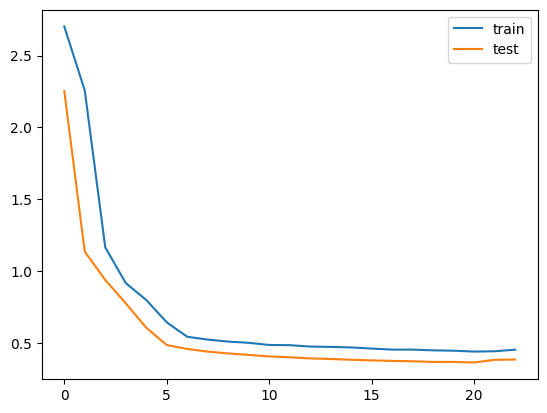

In [38]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [39]:
model.save("/content/gdrive/MyDrive/lstm.h5")

In [40]:
from nltk.translate.bleu_score import corpus_bleu
from keras.models import load_model
from keras import metrics

# Assuming `y_val` are the reference summaries and `y_pred` are the generated summaries
# Convert tokenized summaries to lists of tokenized words
references = [[str(ref).split()] for ref in y_val] # Convert each element of y_val to a string before splitting

# Load the saved model
model = load_model("/content/gdrive/MyDrive/lstm.h5")

# Compile the model with the appropriate metrics - replace 'accuracy' and other parameters
# with the ones you used during training
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Generate predictions using the loaded model
y_pred = model.predict([x_val, y_val[:,:-1]]) # Pass both x_val and y_val[:, :-1] as inputs

# Convert predictions to text (assuming your model outputs numerical tokens)
# This is a placeholder - you'll need to adapt this to your specific model output and vocabulary
y_pred = [' '.join([str(int(i[0])) for i in pred]) for pred in y_pred] # Access the first element of i

hypotheses = [pred.split() for pred in y_pred]

# Calculate BLEU score
bleu_score = corpus_bleu(references, hypotheses)
print("BLEU Score:", bleu_score)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
BLEU Score: 0.6475104955504319
